### Notebook Setup and Initial Configuration

- Import libraries and call `setup_notebook()` for GPU detection and seed initialisation.
- Import global configuration from `config.py` and set `DATASET_VERSION` to "relabelled".
- Add the parent directory to the system path to allow importing modules from `src/zero_shot/testing`.

### Data Loading and Preprocessing

- Loads dataset splits (train, validation, test) from TSV files using DALI.
- Applies preprocessing steps such as resizing, normalisation, and cropping.
- Prepares data consistently for training and evaluation.


In [1]:
# In[1]:
from utils import setup_notebook

# This replicates your existing path additions, warnings, seeds, GPU detection, etc.
setup_notebook()

# Optionally, after calling setup_notebook, you can tweak config:
import config

config.DATASET_VERSION = "augmented"  # or "relabelled"
config.RETRAIN_MODELS = True  # or True, as needed
config.RELABELLING = False

# The custom modules that rely on the path & environment being properly set
from src.core import model_setup, model_trainer, model_tester
from src.analysis import (
    model_analyser,
    class_imbalance,
    calibration_analysis,
    manual_audit,
)
from src.data import load_dali
from src.utils import callbacks

import torch
import copy
from tqdm import tqdm

# Check if CUDA is available and set PyTorch to use CUDA
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

[setup_notebook] Using device: cuda


/home/evammun/anaconda3/envs/Thesis/lib/python3.12/site-packages/nvidia/dali/backend.py:53: Warning: DALI support for Python 3.12 is experimental and some functionalities may not work.
  deprecation_warning(


Using device: cuda


### Model Setup and Optimizer Creation

- Initialises the CNN model (e.g. ResNet50) with multi-task output heads via `initialize_model`.
- Creates an Adam optimizer using a specified learning rate.
- Defines separate CrossEntropyLoss functions for each task.
- Executes the training loop if retraining is enabled.
- Uses DALI data loaders to feed training data.
- Implements early stopping callbacks to monitor validation performance.
- Logs performance metrics such as accuracy and F1 scores.


In [2]:
# Use other config valuesprint(config.get_model_dir())

print(config.get_data_paths())
print(config.get_model_dir())
print(config.DATASET_VERSION)

model_name = "resnet50"
model = model_setup.initialize_model(
    model_name
)  # uses NUM_CLASSES from config by default

optimizer = model_trainer.create_optimizer(model, learning_rate=config.LEARNING_RATE)

criterion = {
    "disaster_types": torch.nn.CrossEntropyLoss(),
    "informative": torch.nn.CrossEntropyLoss(),
    "humanitarian": torch.nn.CrossEntropyLoss(),
    "damage_severity": torch.nn.CrossEntropyLoss(),
}


early_stopping = callbacks.EarlyStopping(config.INITIAL_PATIENCE, verbose=True)
callbacks = [early_stopping]
num_epochs = 100

{'train': '/home/evammun/Thesis/Dataset/MEDIC_train_augmented.tsv', 'val': '/home/evammun/Thesis/Dataset/MEDIC_dev_relabelled.tsv', 'test': '/home/evammun/Thesis/Dataset/MEDIC_test_relabelled.tsv'}
models/augmented
augmented


### Model Evaluation and Testing

- Loads saved model checkpoints for each architecture.
- Runs inference on the test set using the DALI test loader.
- Collects true labels and predictions to compute evaluation metrics.


In [3]:
if config.RETRAIN_MODELS:
    resnet_trained_model, best_val_accuracy, best_val_f1 = model_trainer.train_model(
        model,
        model_name,
        data_dir=config.DATA_DIR,
        criterion=criterion,
        optimizer=optimizer,
        learning_rate=config.LEARNING_RATE,
        initial_patience=config.INITIAL_PATIENCE,
        num_epochs=num_epochs,
        device=device,
        batch_size=config.BATCH_SIZE,
        num_threads=config.NUM_THREADS,
        callbacks=callbacks,
        delete_tensorboard=True,
    )

Val Phase, Epoch 14: 100%|██████████| 193/193 [00:13<00:00, 14.06it/s]


Triggering learning rate reduction


Val Phase, Epoch 24: 100%|██████████| 193/193 [00:13<00:00, 14.40it/s]


Early stopping triggered
Early stopping triggered.


In [4]:
if config.RETRAIN_MODELS:

    # Initialize model, optimizer, and loss

    model_name = "efficientnet_b1"
    model = model_setup.initialize_model(
        model_name
    )  # uses NUM_CLASSES from config by default

    optimizer = model_trainer.create_optimizer(
        model, learning_rate=config.LEARNING_RATE
    )
    efficientnet_trained_model, best_val_accuracy, best_val_f1 = (
        model_trainer.train_model(
            model,
            model_name,
            data_dir=config.DATA_DIR,
            criterion=criterion,
            optimizer=optimizer,
            learning_rate=config.LEARNING_RATE,
            initial_patience=config.INITIAL_PATIENCE,
            num_epochs=num_epochs,
            device=device,
            batch_size=config.BATCH_SIZE,
            num_threads=config.NUM_THREADS,
            callbacks=callbacks,
            delete_tensorboard=False,
        )
    )

Val Phase, Epoch 31: 100%|██████████| 193/193 [00:10<00:00, 18.88it/s]


Triggering learning rate reduction


Val Phase, Epoch 41: 100%|██████████| 193/193 [00:08<00:00, 21.94it/s]


Early stopping triggered
Early stopping triggered.


In [ ]:
if config.RETRAIN_MODELS:

    # Initialize model, optimizer, and loss

    model_name = "mobilenet_v2"
    model = model_setup.initialize_model(
        model_name
    )  # uses config.NUM_CLASSES from config by default

    optimizer = model_trainer.create_optimizer(
        model, learning_rate=config.LEARNING_RATE
    )
    mobilenet_trained_model, best_val_accuracy, best_val_f1 = model_trainer.train_model(
        model,
        model_name,
        data_dir=config.DATA_DIR,
        criterion=criterion,
        optimizer=optimizer,
        learning_rate=config.LEARNING_RATE,
        initial_patience=config.INITIAL_PATIENCE,
        num_epochs=num_epochs,
        device=device,
        batch_size=config.BATCH_SIZE,
        num_threads=config.NUM_THREADS,
        callbacks=callbacks,
        delete_tensorboard=False,
    )

Val Phase, Epoch 29: 100%|██████████| 193/193 [00:06<00:00, 31.41it/s]


Triggering learning rate reduction


Val Phase, Epoch 39: 100%|██████████| 193/193 [00:06<00:00, 30.20it/s]


Early stopping triggered
Early stopping triggered.


### Model Evaluation and Testing

- Loads saved model checkpoints for each architecture.
- Runs inference on the test set using the DALI test loader.
- Collects true labels and predictions to compute evaluation metrics.


In [24]:
# Run the analysis
results = model_analyser.analyse_all_models()

[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_resnet50.pth
[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_efficientnet_b1.pth
[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_mobilenet_v2.pth


In [25]:
model_analyser.display_comparative_table(results)

### Analysis and Visualisation of Results

- Generates confusion matrices for each classification task.
- Identifies top label combinations contributing to errors.
- Displays comparative tables of model performance.


[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_resnet50.pth
resnet50


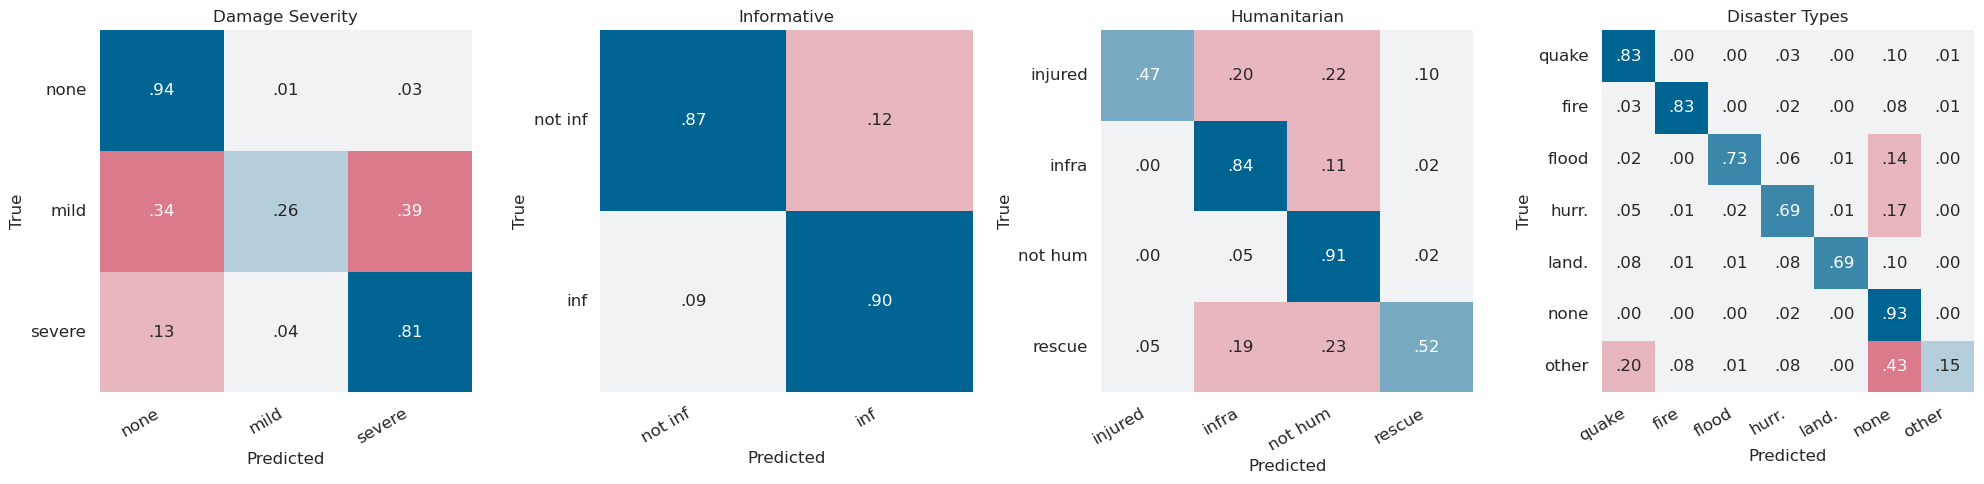

[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_efficientnet_b1.pth
efficientnet_b1


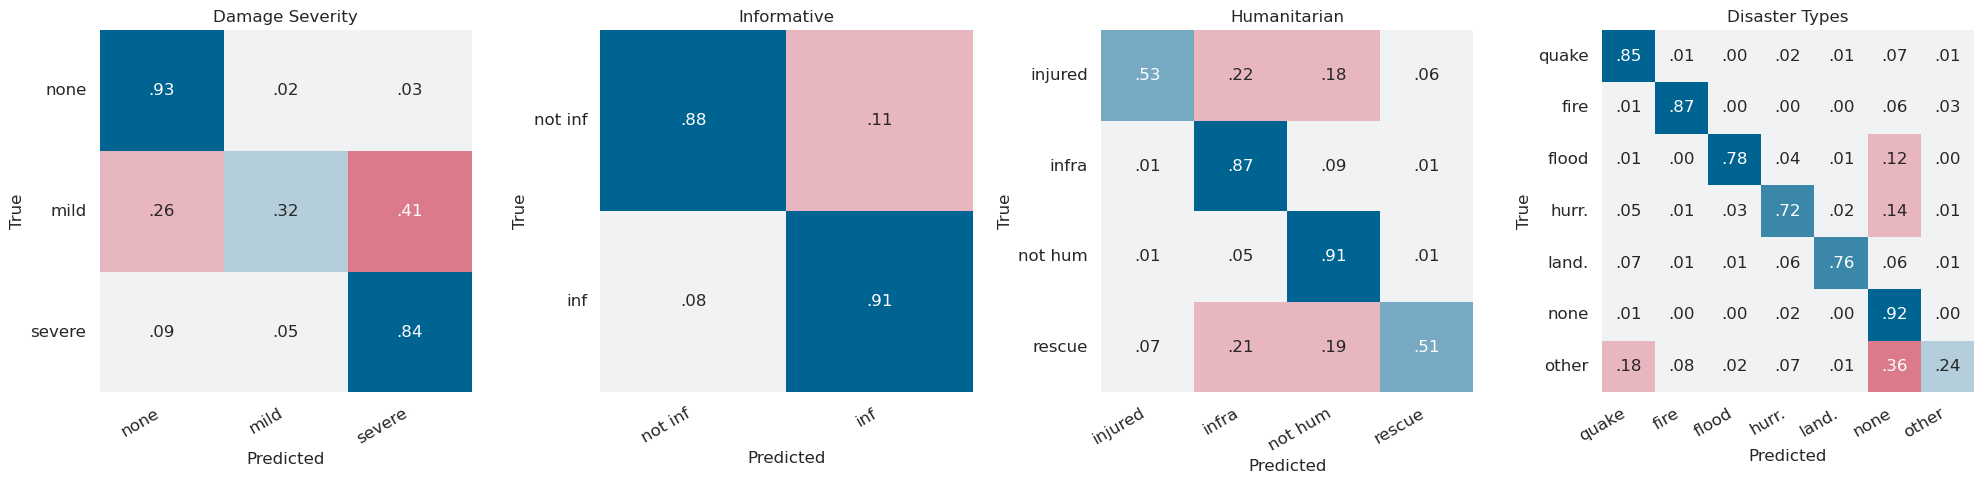

[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_mobilenet_v2.pth
mobilenet_v2


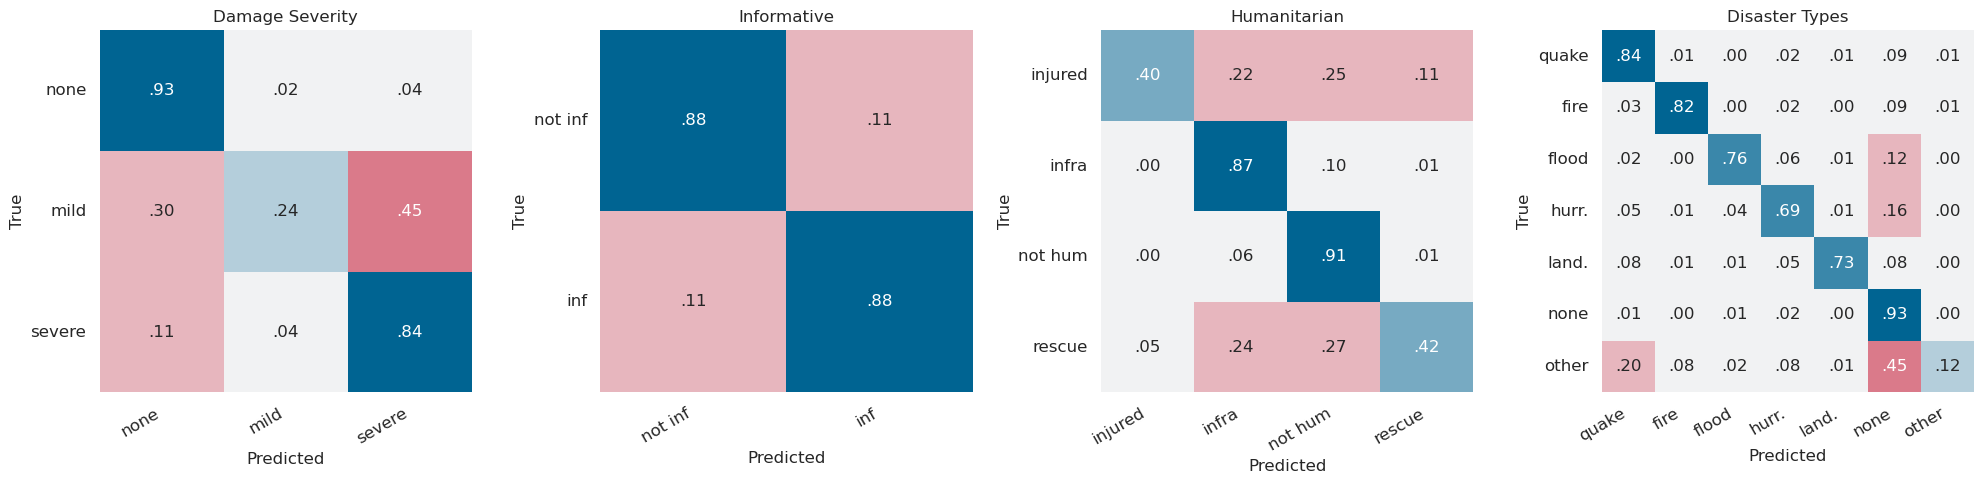

In [8]:
conf_save_dir = "results/confusion_matrices"
models_results = []

for model_name, model_path in config.MODEL_PATHS.items():
    model = model_tester.load_model(model_name, model_path)
    true_labels, predictions, _ = model_tester.test_model(
        model, config.DATA_DIR, config.BATCH_SIZE, config.NUM_THREADS
    )
    models_results.append((model_name, true_labels, predictions))
    print(model_name)
    model_analyser.plot_confusion_matrices(
        true_labels, predictions, save_dir=conf_save_dir
    )

In [9]:
model_analyser.plot_full_confusion_matrices(
    true_labels, predictions, save_dir=conf_save_dir
)

In [10]:
df_subsets = model_analyser.top_label_combos_by_error_contribution(
    top_n=20, min_support=10, display_html=True
)

In [11]:
df_pair_combos = model_analyser.pair_label_combos_by_error_contribution(
    top_n=20, min_support=10, display_html=True
)

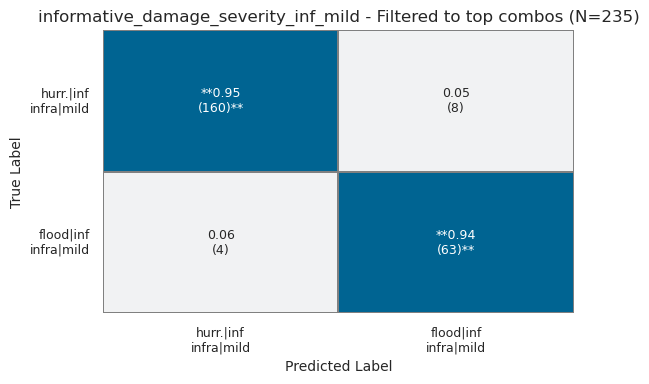

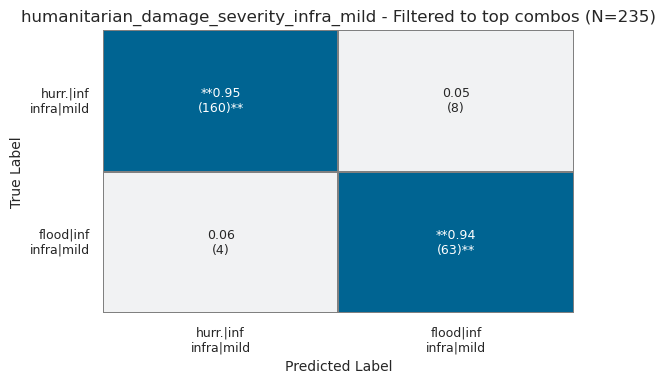

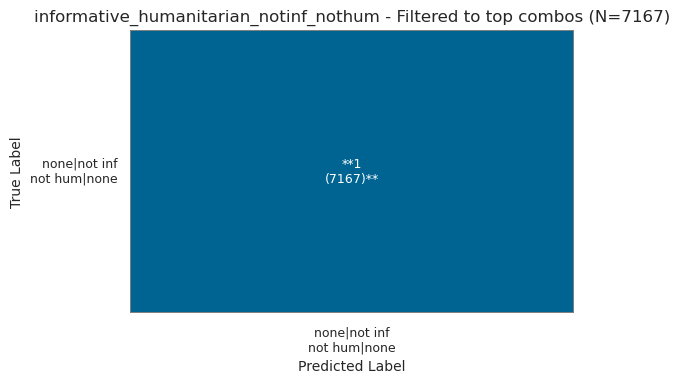

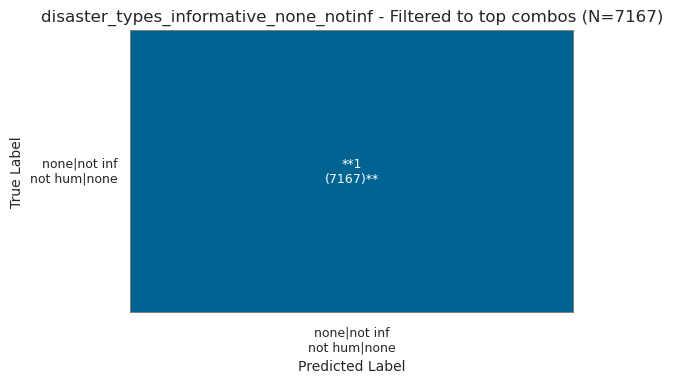

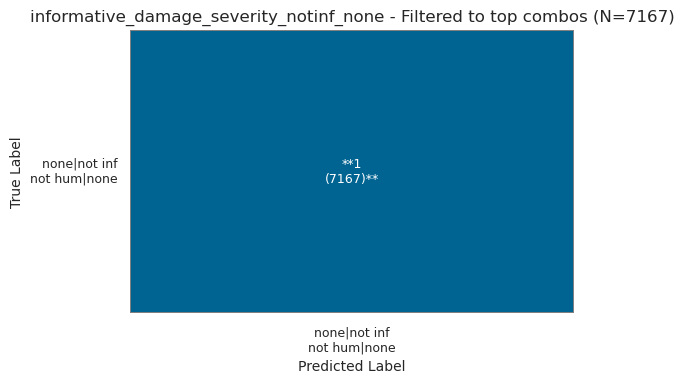

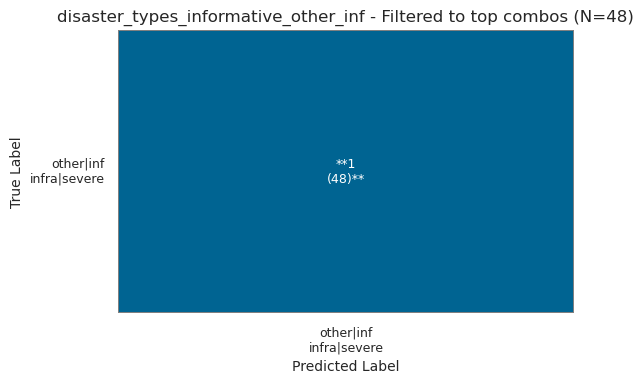

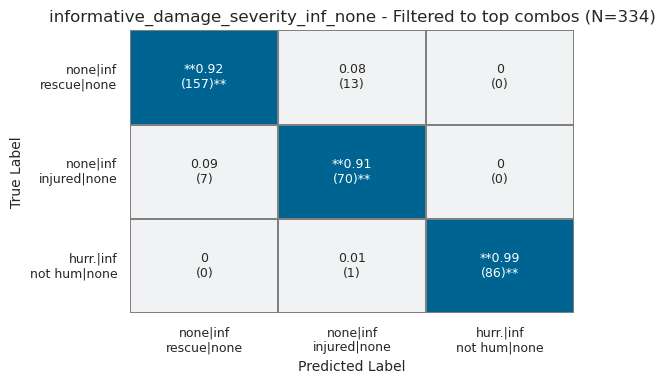

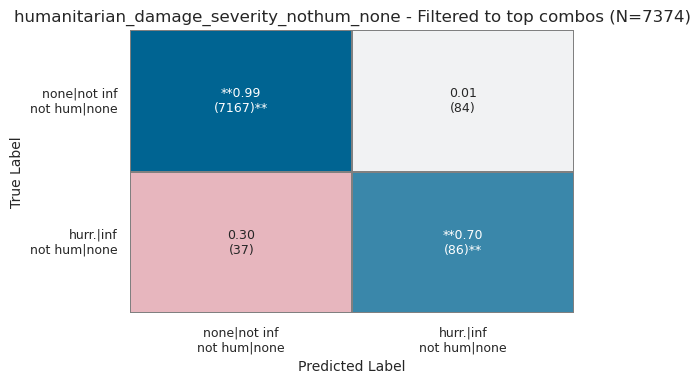

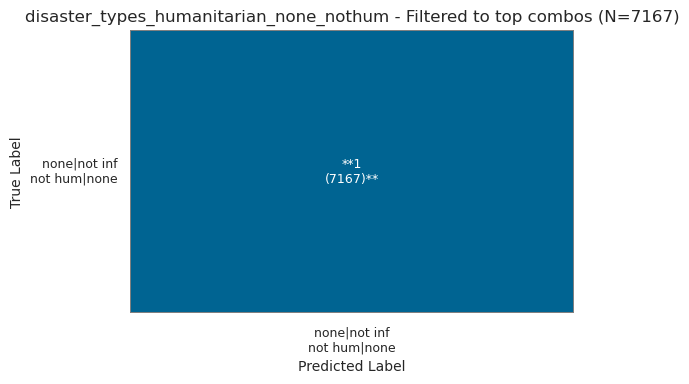

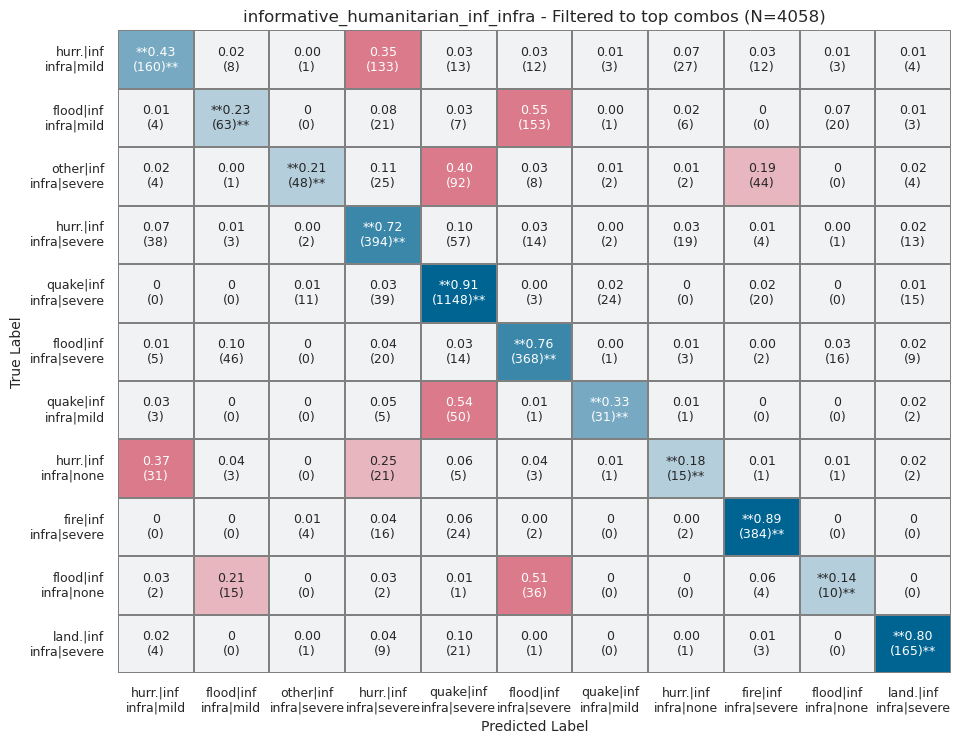

In [12]:
model_analyser.plot_confusion_subsets(
    true_labels,
    predictions,
    save_dir=conf_save_dir,
    min_support=10,
    subsets_of_interest=[
        {
            "name": "informative_damage_severity_inf_mild",
            "conditions": {
                "informative": ["inf"],
                "damage_severity": ["mild"],
            },
        },
        {
            "name": "humanitarian_damage_severity_infra_mild",
            "conditions": {
                "humanitarian": ["infra"],
                "damage_severity": ["mild"],
            },
        },
        {
            "name": "informative_humanitarian_notinf_nothum",
            "conditions": {
                "informative": ["not inf"],
                "humanitarian": ["not hum"],
            },
        },
        {
            "name": "disaster_types_informative_none_notinf",
            "conditions": {
                "disaster_types": ["none"],
                "informative": ["not inf"],
            },
        },
        {
            "name": "informative_damage_severity_notinf_none",
            "conditions": {
                "informative": ["not inf"],
                "damage_severity": ["none"],
            },
        },
        {
            "name": "disaster_types_informative_other_inf",
            "conditions": {
                "disaster_types": ["other"],
                "informative": ["inf"],
            },
        },
        {
            "name": "informative_damage_severity_inf_none",
            "conditions": {
                "informative": ["inf"],
                "damage_severity": ["none"],
            },
        },
        {
            "name": "humanitarian_damage_severity_nothum_none",
            "conditions": {
                "humanitarian": ["not hum"],
                "damage_severity": ["none"],
            },
        },
        {
            "name": "disaster_types_humanitarian_none_nothum",
            "conditions": {
                "disaster_types": ["none"],
                "humanitarian": ["not hum"],
            },
        },
        {
            "name": "informative_humanitarian_inf_infra",
            "conditions": {
                "informative": ["inf"],
                "humanitarian": ["infra"],
            },
        },
    ],
)

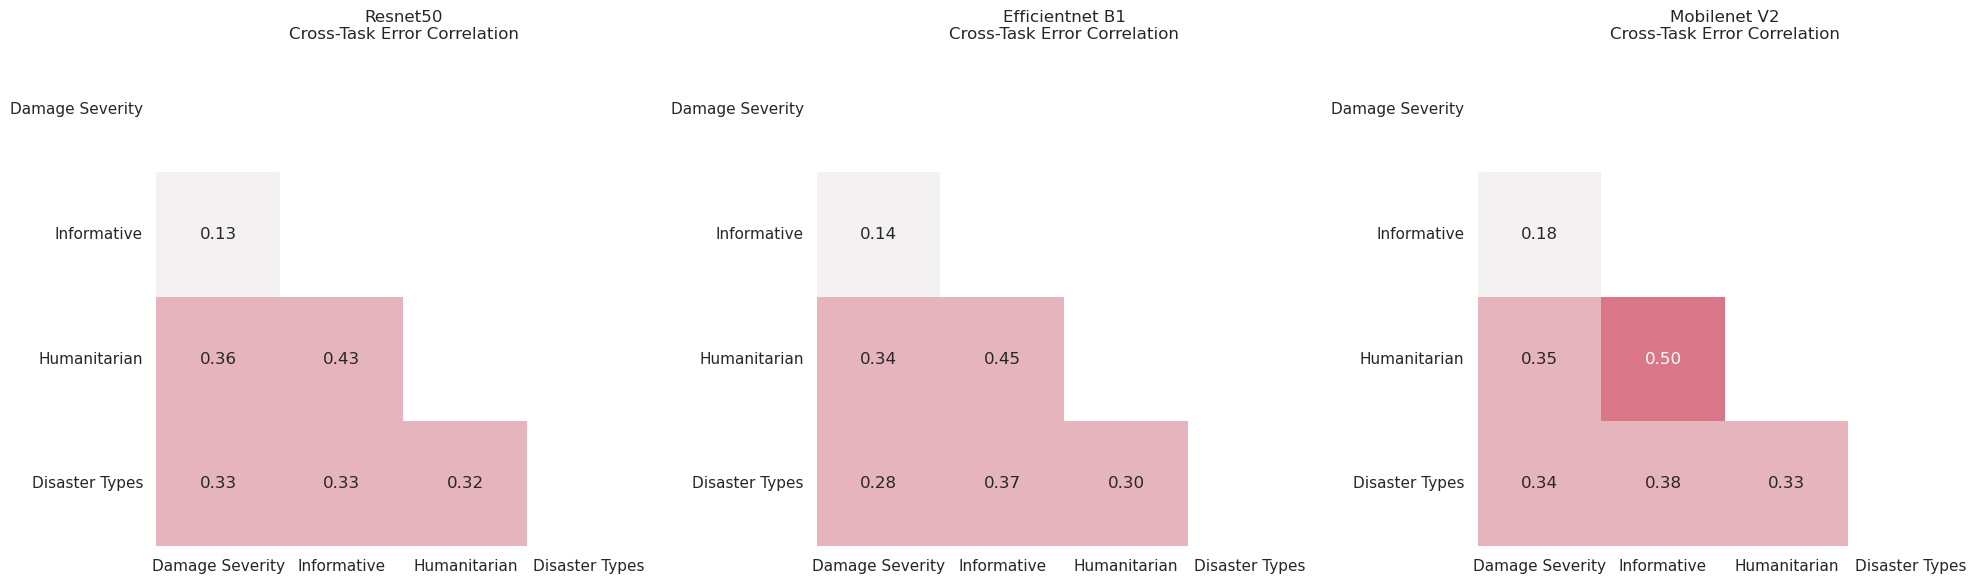

In [13]:
cross_task_save_dir = "results/cross_task_errors"

model_analyser.plot_cross_task_errors(models_results, save_dir=cross_task_save_dir)

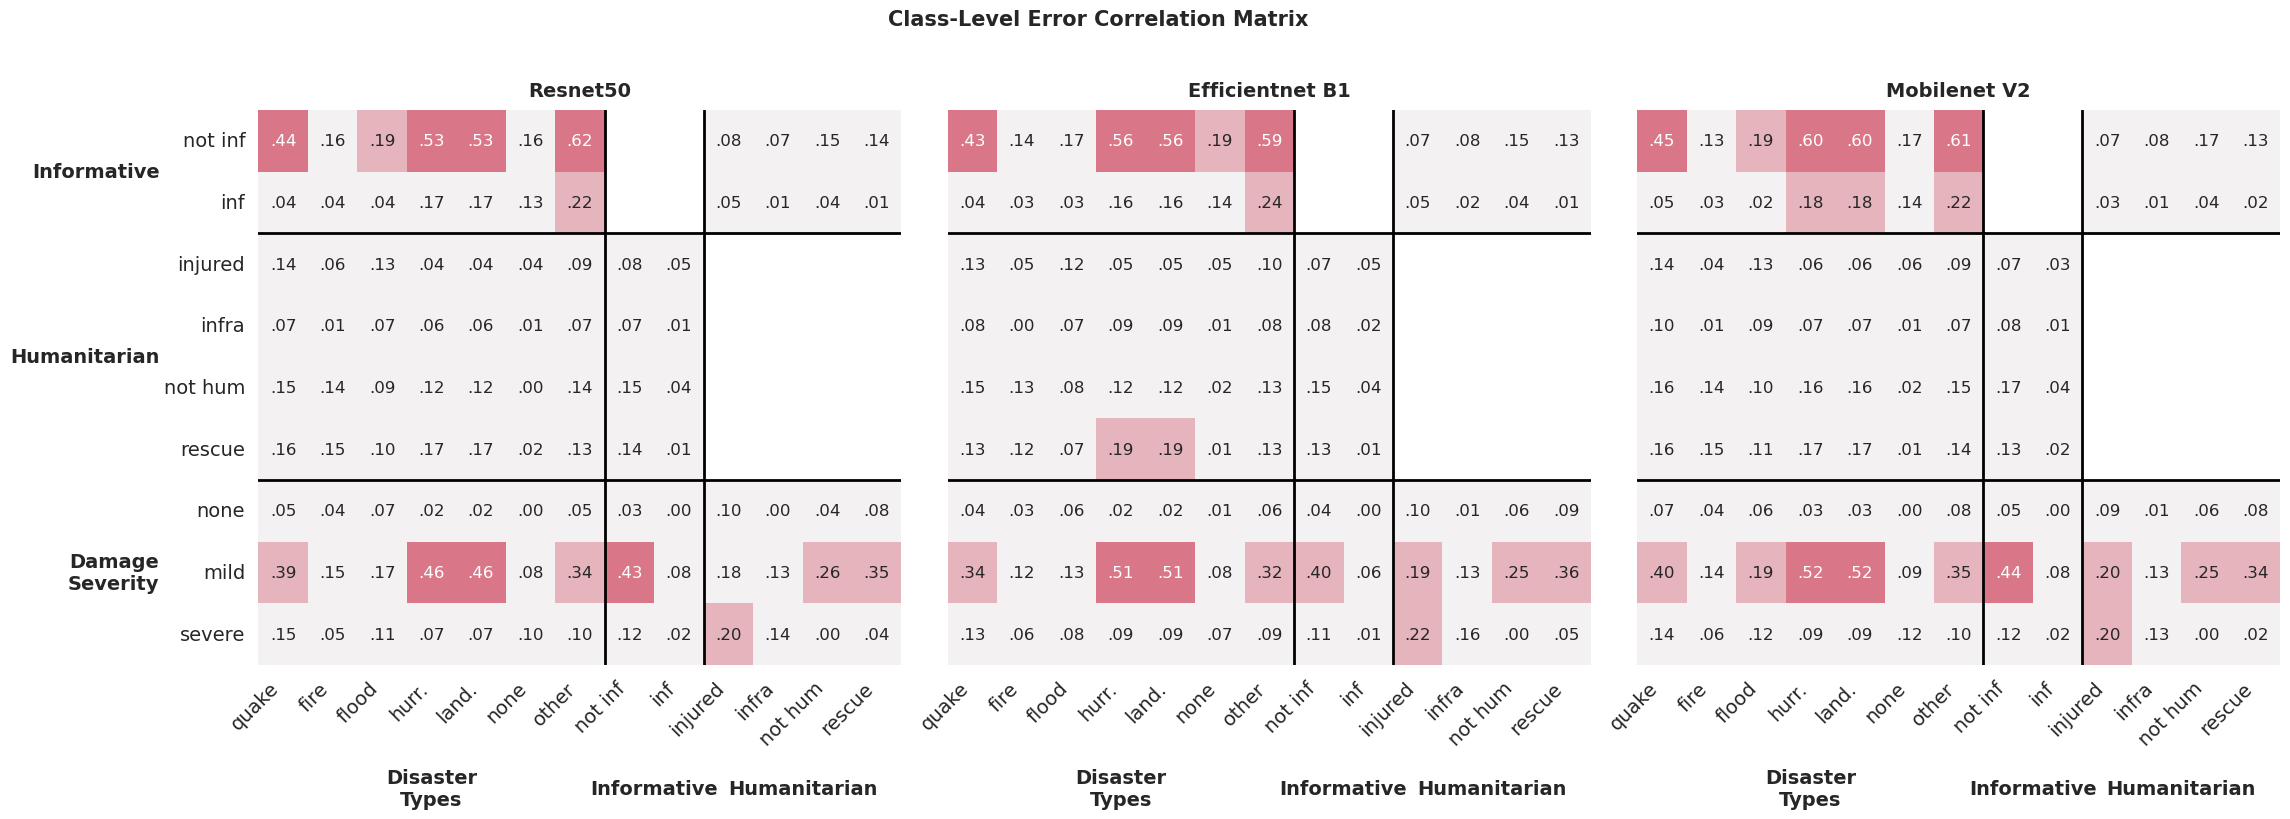

In [14]:
for model_name, true_labels, predictions in models_results:
    model_analyser.plot_class_error_matrix(
        model_name, true_labels, predictions, "results/class_errors"
    )

[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_resnet50.pth
[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_efficientnet_b1.pth
[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_mobilenet_v2.pth


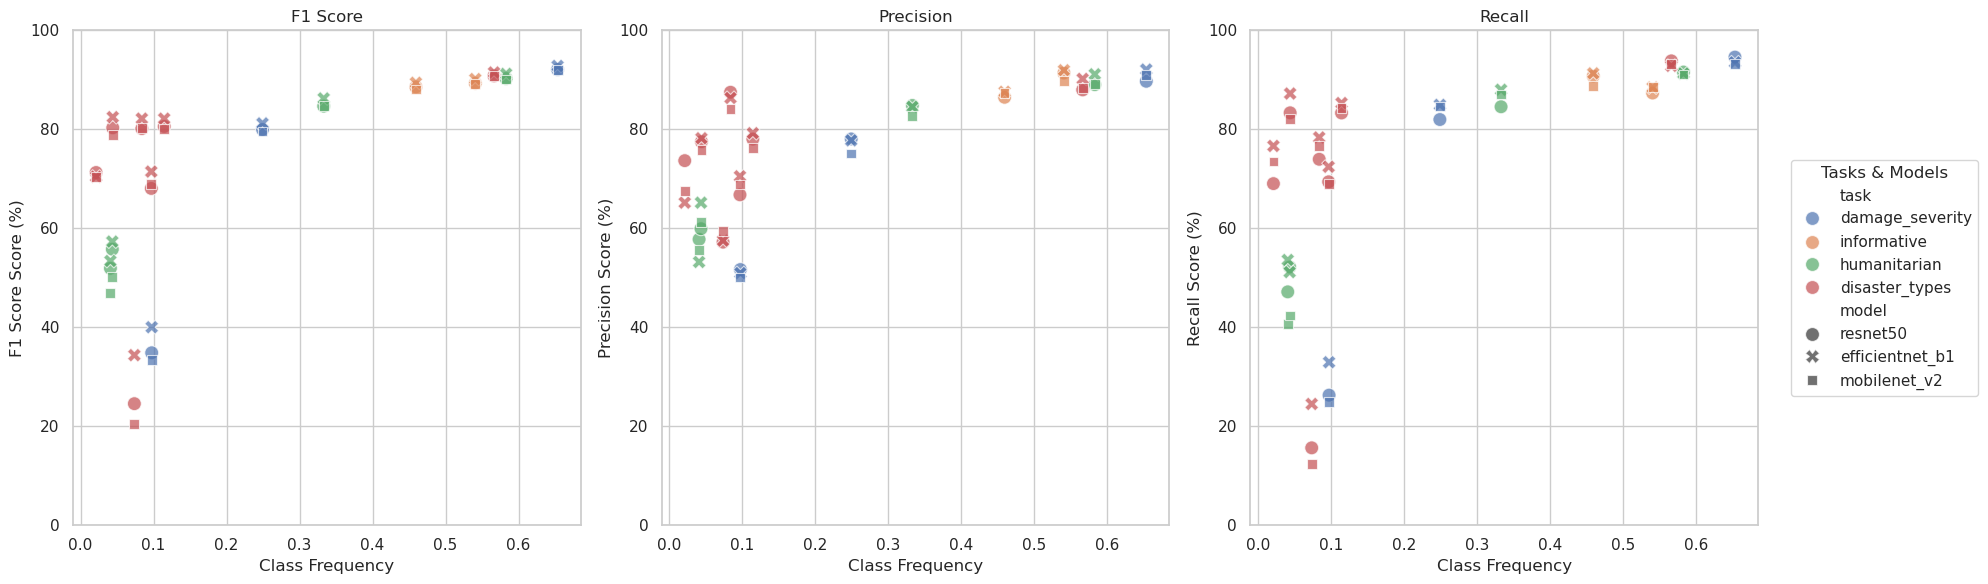

In [15]:
class_imbalance.analyze_class_imbalance_effects()

In [16]:
class_imbalance.analyze_class_imbalance_table()

[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_resnet50.pth
[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_efficientnet_b1.pth
[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_mobilenet_v2.pth


[analyze_calibration] Loading resnet50 from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_resnet50.pth
[analyze_calibration] Loading efficientnet_b1 from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_efficientnet_b1.pth
[analyze_calibration] Loading mobilenet_v2 from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_mobilenet_v2.pth


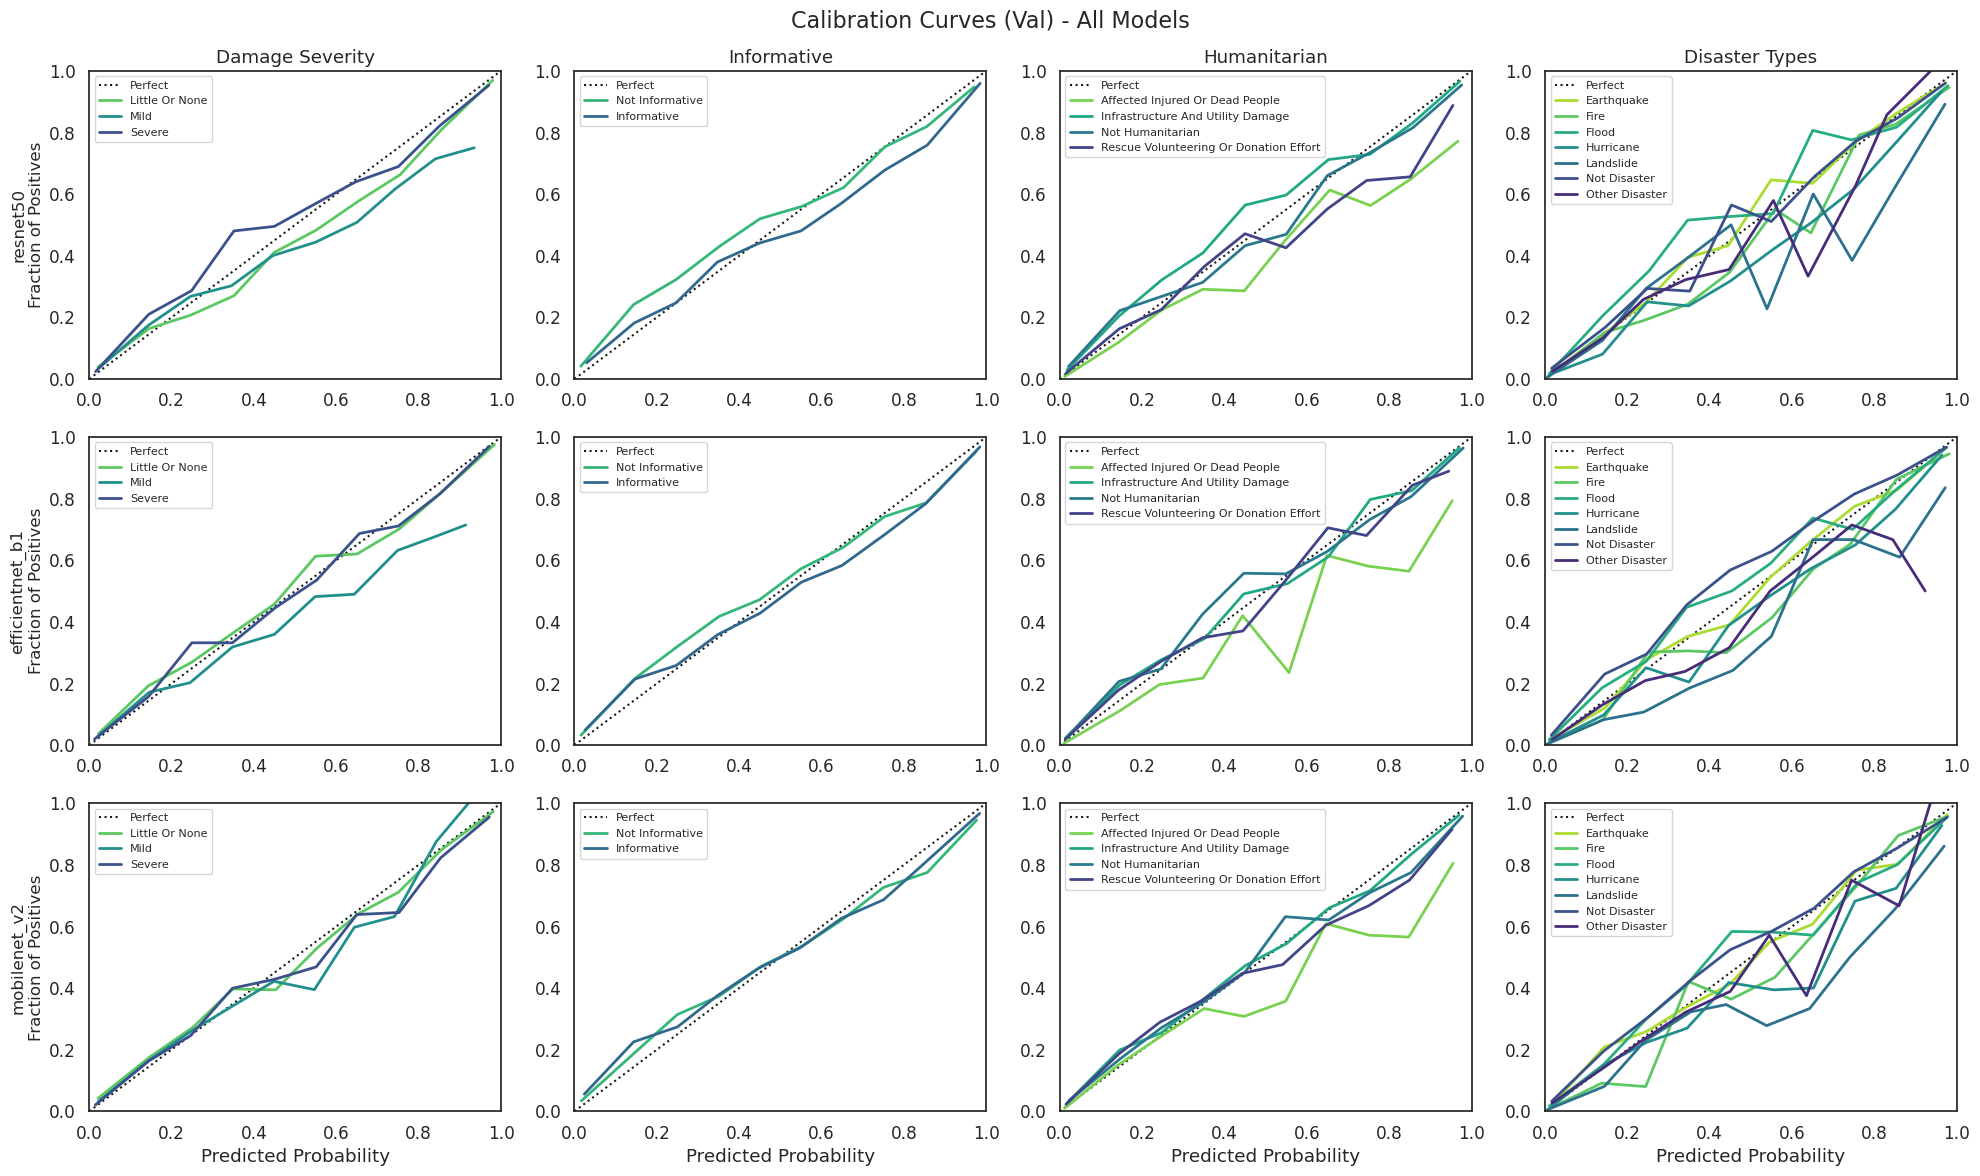

In [17]:
calibration_analysis.analyze_calibration(phase="val")

[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_resnet50.pth
[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_efficientnet_b1.pth
[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_mobilenet_v2.pth
Found 5 candidate images; showing up to 5 below:




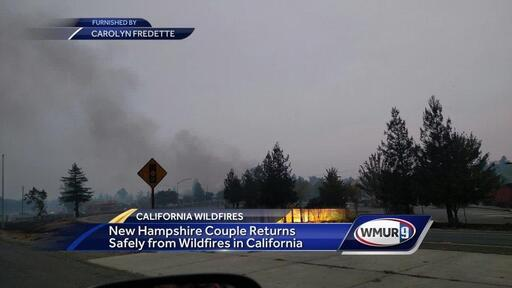

----------------------------------------------------------------------



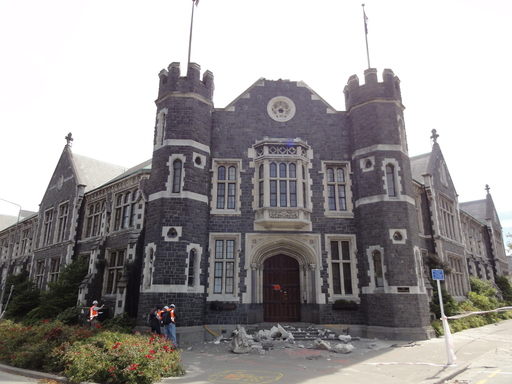

----------------------------------------------------------------------



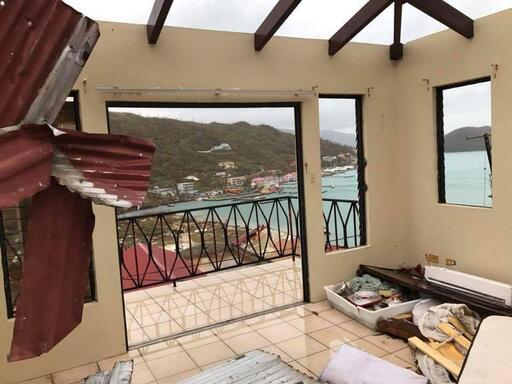

----------------------------------------------------------------------



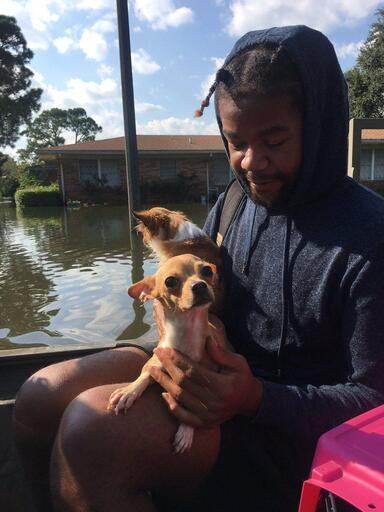

----------------------------------------------------------------------



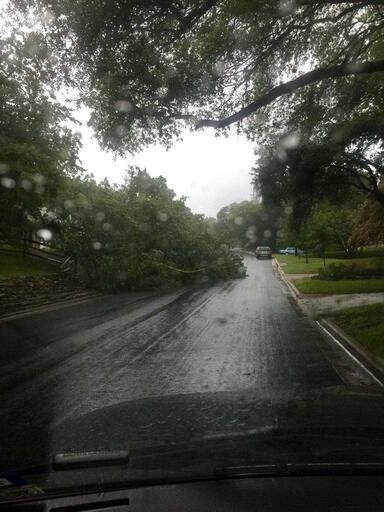

----------------------------------------------------------------------



In [18]:
classes_to_inspect = {
    "informative": ["informative"],
    "damage_severity": ["mild"],
}

manual_audit.run_qualitative_audit(
    classes_to_inspect=classes_to_inspect,
    misclassified_by=2,
    sample_size=5,
    images_to_show=5,
)

### Embedding Analysis

- Extracts penultimate layer embeddings from the trained model.
- Applies dimensionality reduction techniques like t-SNE and UMAP.
- Produces plots to assess feature space separability.


[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_efficientnet_b1.pth


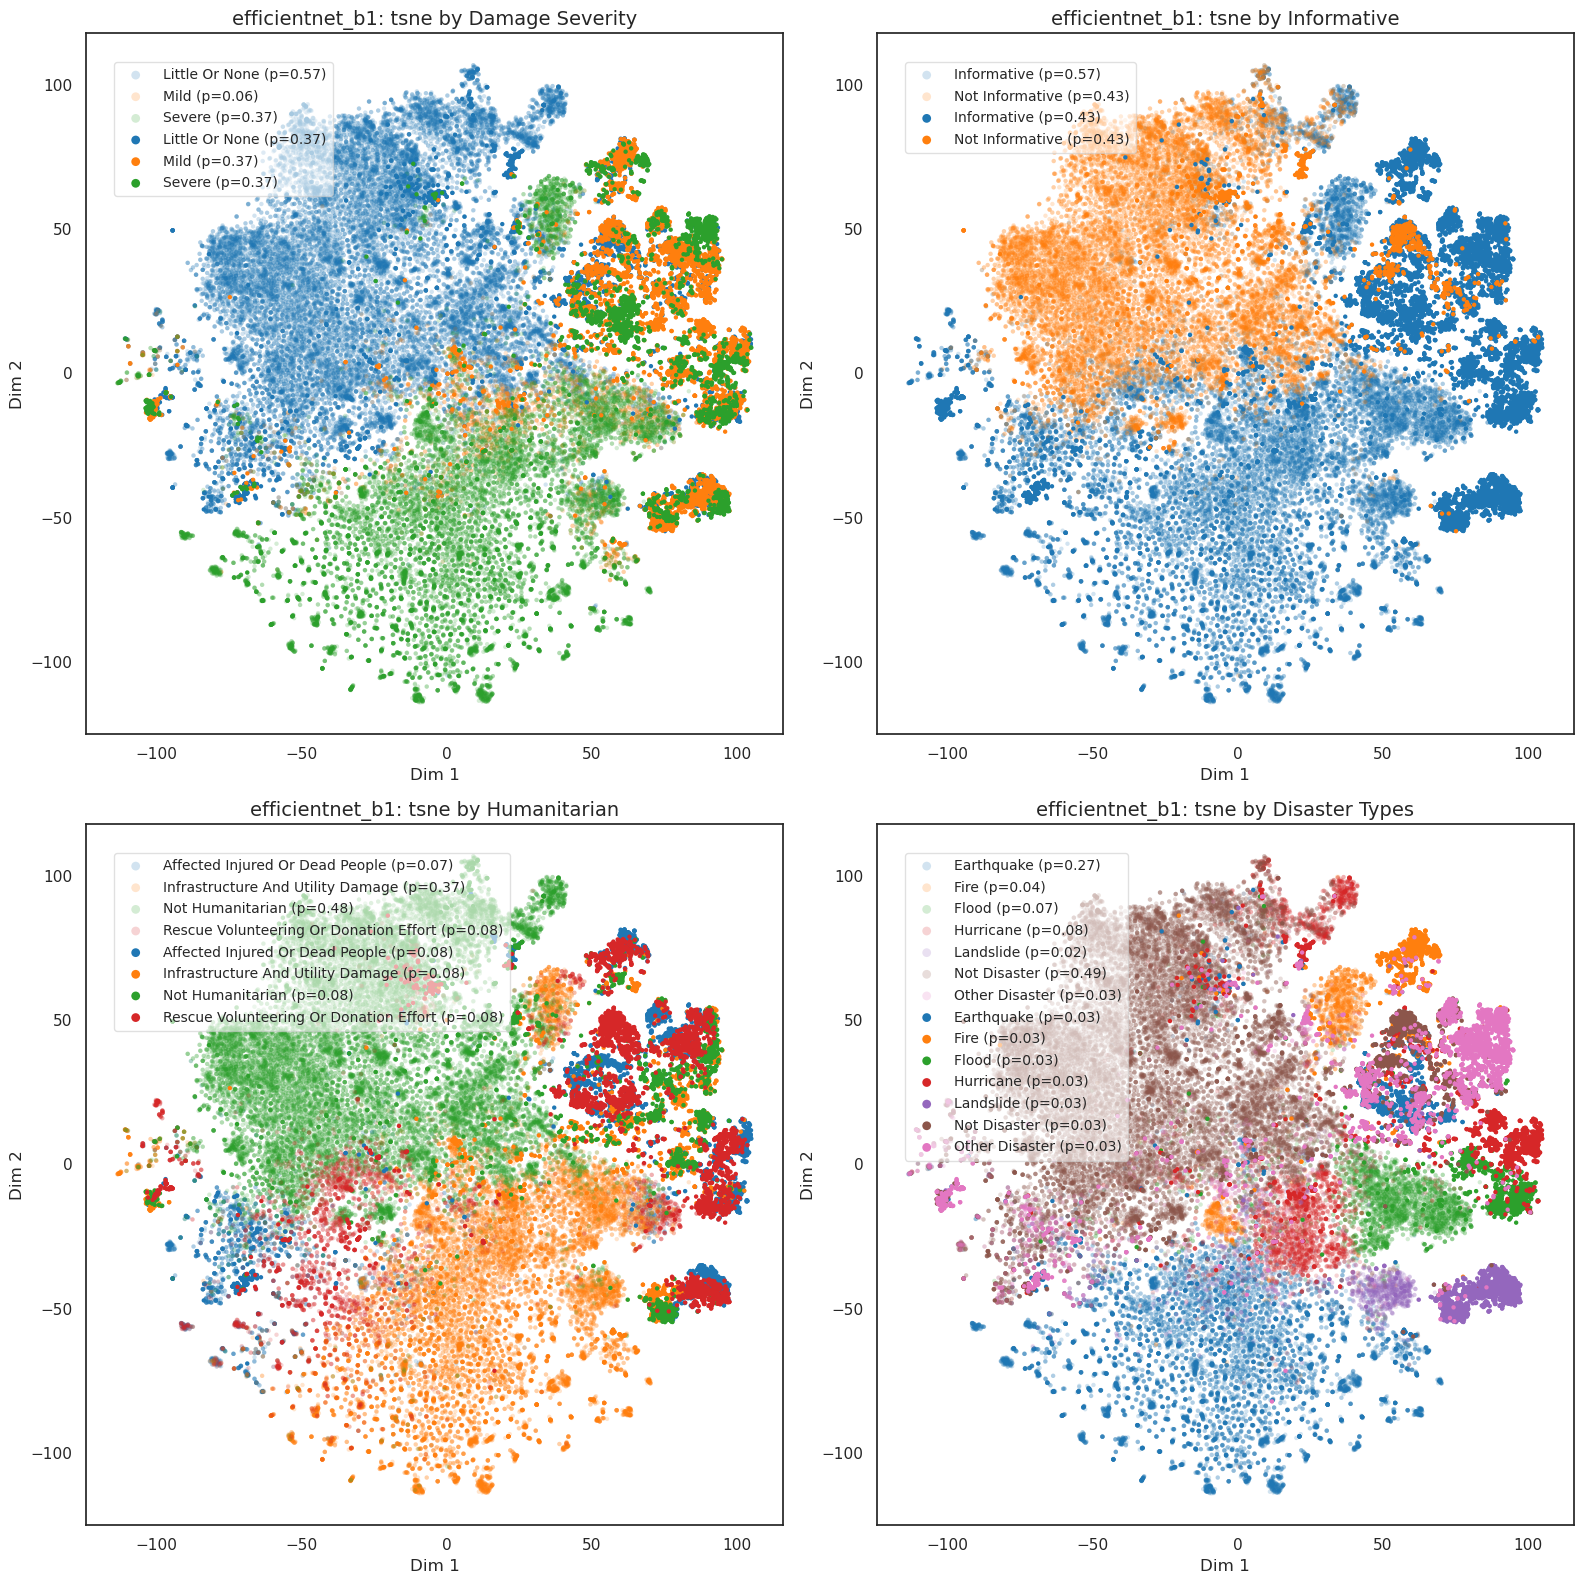

In [35]:
from src.analysis.embedding_analysis import analyze_penultimate_embeddings_synthetic

model_name = "efficientnet_b1"
model_ckpt = config.MODEL_PATHS["efficientnet_b1"]

analyze_penultimate_embeddings_synthetic(
    model_name=model_name,
    model_ckpt=model_ckpt,
    reduction_method="tsne",
    n_components=2,
)

[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_efficientnet_b1.pth


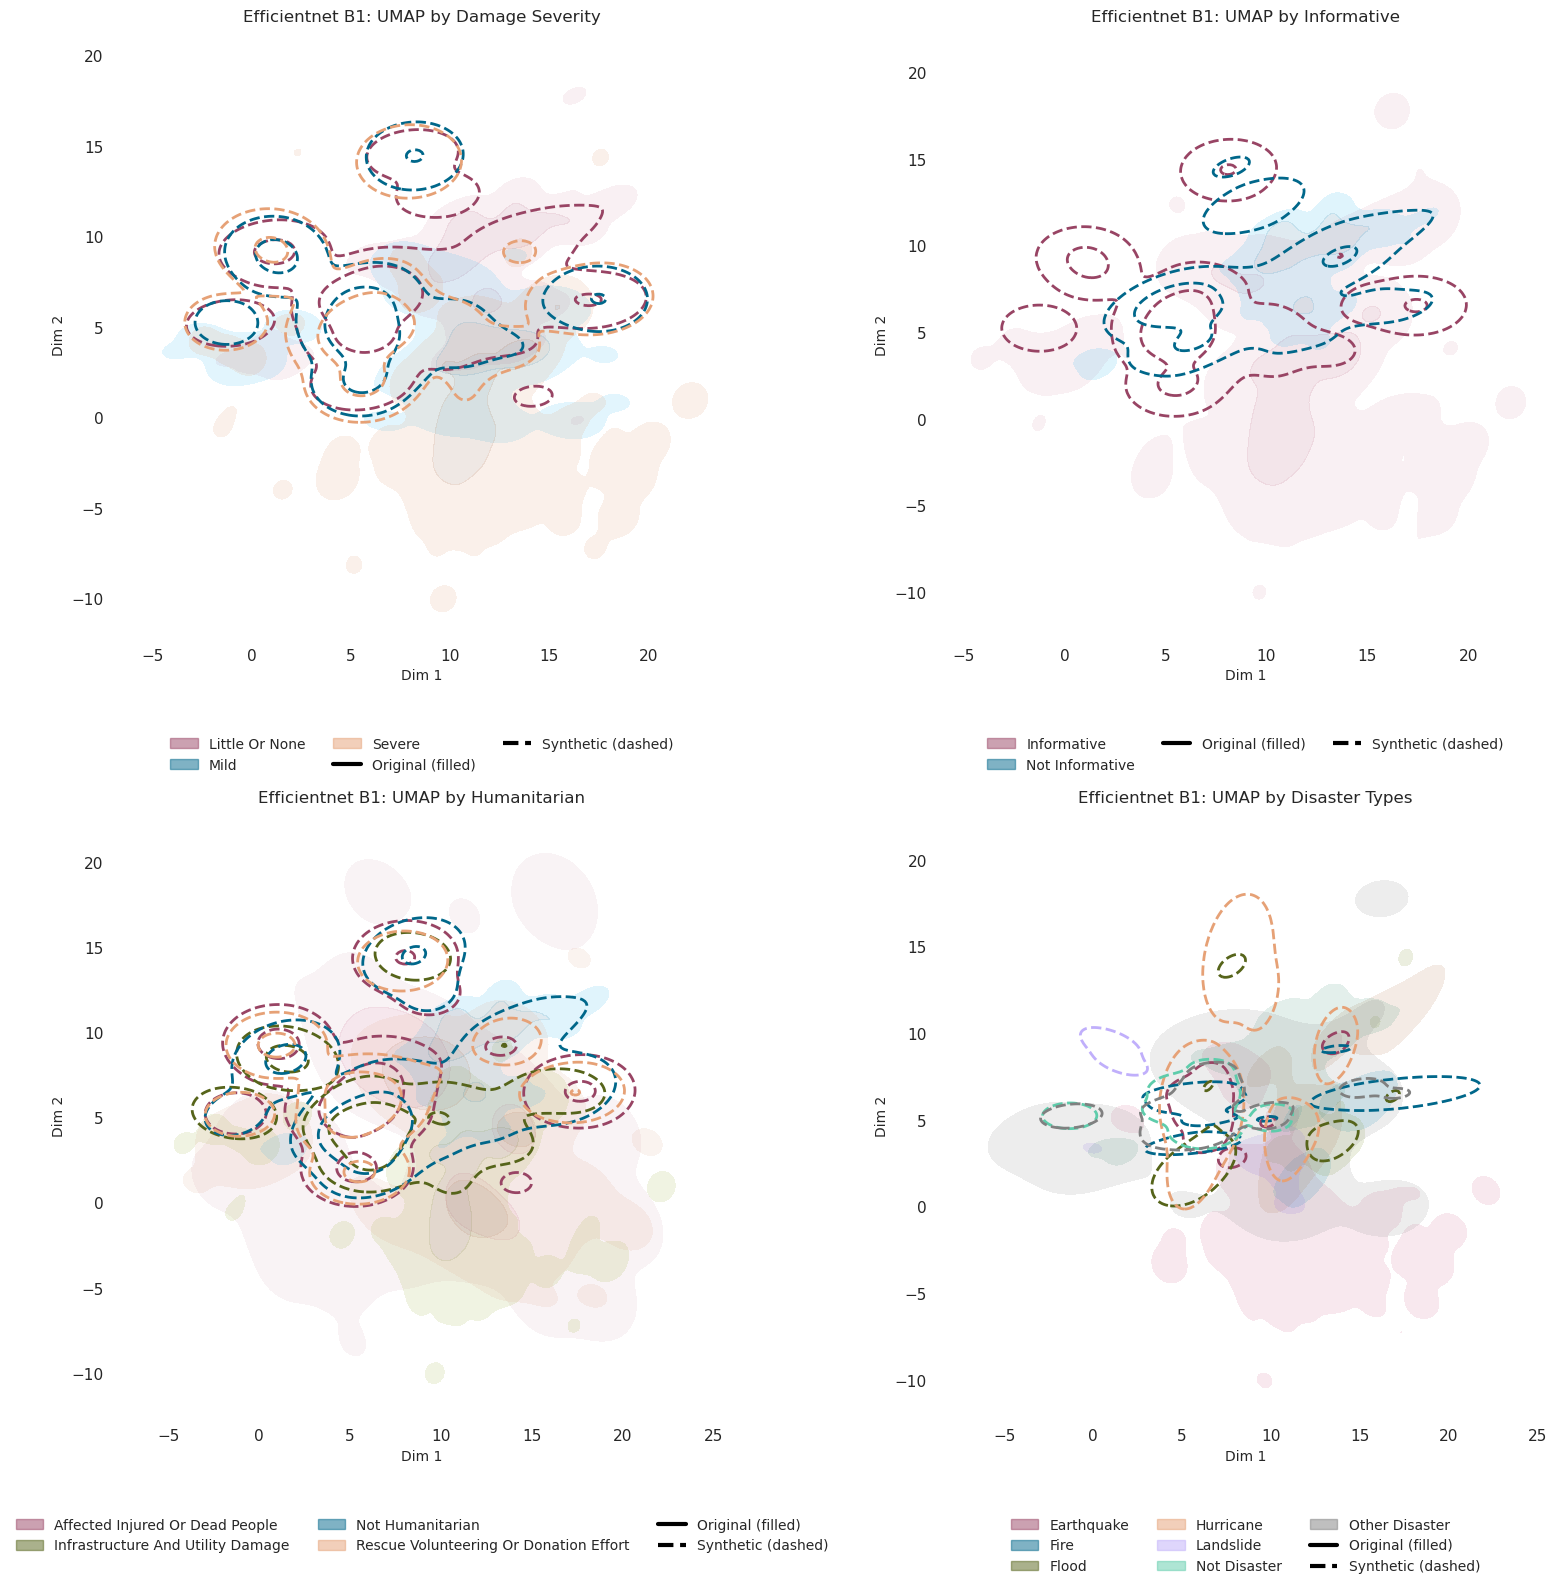

In [8]:
from src.analysis.embedding_analysis import (
    analyze_penultimate_embeddings_synthetic_density,
)

model_name = "efficientnet_b1"
model_ckpt = config.MODEL_PATHS["efficientnet_b1"]

analyze_penultimate_embeddings_synthetic_density(
    model_name=model_name,
    model_ckpt=model_ckpt,
    reduction_method="umap",
    n_components=2,
)

[load_model] Loading checkpoint from: /home/evammun/Thesis/WSLcode/models/augmented/best_model_efficientnet_b1.pth


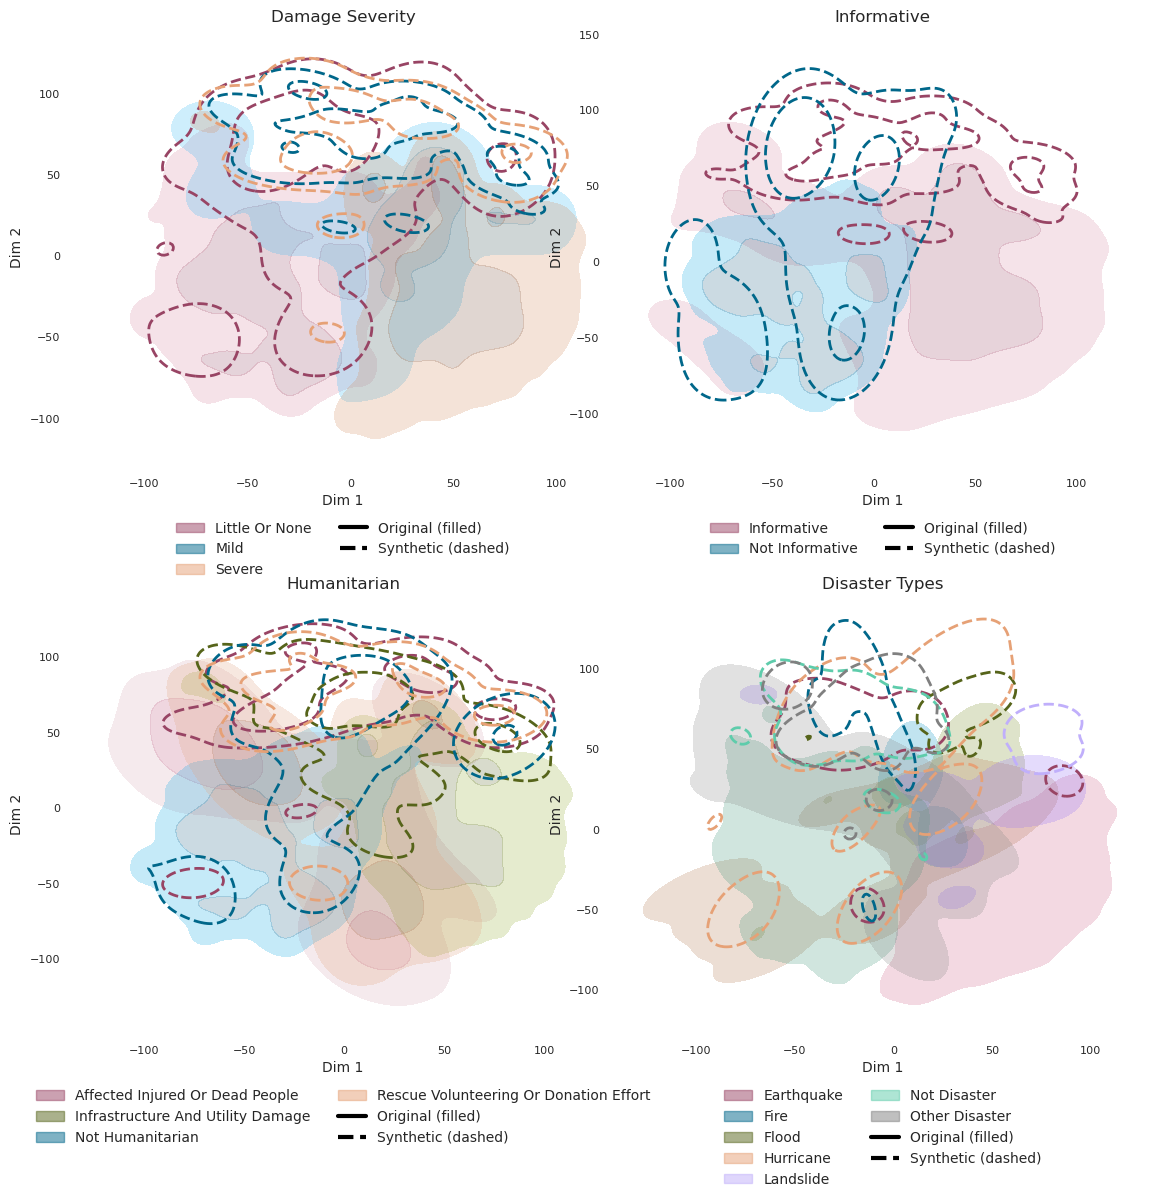

In [9]:
from src.analysis.embedding_analysis import (
    analyze_penultimate_embeddings_synthetic_density,
)

model_name = "efficientnet_b1"
model_ckpt = config.MODEL_PATHS["efficientnet_b1"]

analyze_penultimate_embeddings_synthetic_density(
    model_name=model_name,
    model_ckpt=model_ckpt,
    reduction_method="tsne",
    n_components=2,
)